In [1]:
%matplotlib notebook
# %matplotlib inline

# %connect_info
import flow.misc
text = """
Jupyter connect hash:
{word}

To connect to current notebook:
    $> jupyter console --existing {filename}
    
"""
print(text.format(word=flow.misc.notebook_word(), filename=flow.misc.notebook_file(flow.misc.notebook_word())))
print("Last run: {}".format(flow.misc.timestamp()))


Jupyter connect hash:
certified

To connect to current notebook:
    $> jupyter console --existing kernel-afdfc1ed-6c9d-4ed0-bfab-2b37d2aa5cd3.json
    

Last run: 2018-11-01-16h02m04s


/usr/local/lib/python2.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.23) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(context='notebook', style='darkgrid')
# sns.set(context='talk', style='darkgrid')

import jzap
import flow
import pool

In [3]:
date = flow.metadata.Date('OA205', 180925)
date

Date(mouse=OA205, date=180925, tags=(u'jeff',), photometry=())

## Not normalized at all

In [4]:
start_s = -1
end_s = 2
rew_responses = []
for run in date.runs():
    rew_responses.append(run.trace2p().cstraces(
        'reward', trace_type='dff', baseline=None, start_s=start_s,
        end_s=end_s))
framerate = run.trace2p().framerate
all_rew = np.concatenate(rew_responses, 2)
rew = all_rew.mean(2)
order = np.argsort(rew[:, int(start_s * -1 * framerate):].mean(1))
all_rew.shape

(131, 46, 128)

<IPython.core.display.Javascript object>


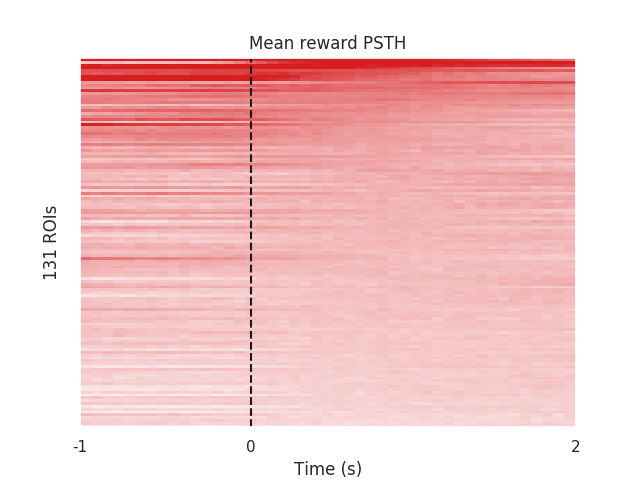

In [5]:
fig, ax = plt.subplots()
pool.plotting.graphfns.axheatmap(fig, ax, rew[order], [], 'dff', 0.3)
ax.axvline(framerate * start_s * -1, linestyle='--', color='k')
ax.set_xticks([0, framerate * start_s * -1, rew.shape[1]-1])
ax.set_xticklabels([start_s, 0, end_s])
ax.set_xlabel('Time (s)')

ax.set_yticklabels([])
ax.set_ylabel(str(rew.shape[0]) + ' ROIs')

ax.set_title('Mean reward PSTH');

In [6]:
start_s = -1
end_s = 2
rew_responses = []
for run in date.runs():
    rew_responses.append(run.trace2p().cstraces(
        'reward', trace_type='dff', baseline=(-2, 0), start_s=start_s,
        end_s=end_s, baseline_to_stimulus=True))
framerate = run.trace2p().framerate
all_rew = np.concatenate(rew_responses, 2)
rew = all_rew.mean(2)
order = np.argsort(rew[:, int(start_s * -1 * framerate):].mean(1))
all_rew.shape

(131, 46, 128)

<IPython.core.display.Javascript object>


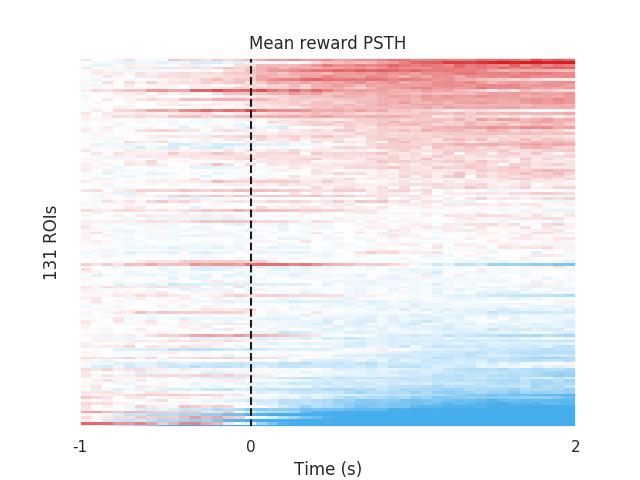

In [7]:
fig, ax = plt.subplots()
pool.plotting.graphfns.axheatmap(fig, ax, rew[order], [], 'dff')
ax.axvline(framerate * start_s * -1, linestyle='--', color='k')
ax.set_xticks([0, framerate * start_s * -1, rew.shape[1]-1])
ax.set_xticklabels([start_s, 0, end_s])
ax.set_xlabel('Time (s)')

ax.set_yticklabels([])
ax.set_ylabel(str(rew.shape[0]) + ' ROIs')

ax.set_title('Mean reward PSTH');

<IPython.core.display.Javascript object>


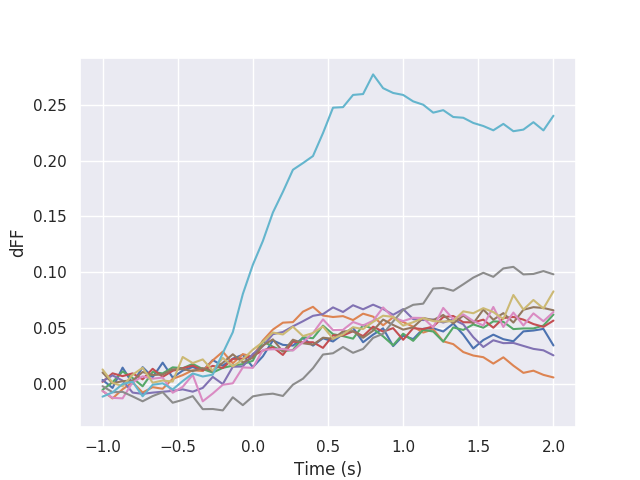

Text(0,0.5,'dFF')

In [8]:
fig, ax = plt.subplots()
ax.plot(np.linspace(start_s, end_s, rew.shape[1]), rew[order[-10:]].T)
ax.set_xlabel('Time (s)')
ax.set_ylabel('dFF')

### Shuffle data sanity check

In [9]:
all_shuffle = np.copy(all_rew)
for roi_idx, roi in enumerate(all_rew):
    for trial_idx, trial in enumerate(roi.T):
        all_shuffle[roi_idx, :, trial_idx] = np.roll(trial, np.random.randint(len(trial)))
all_shuffle -= all_shuffle[:, :15, :].mean(1)[:, None, :]
shuffle = all_shuffle.mean(2)        

<IPython.core.display.Javascript object>


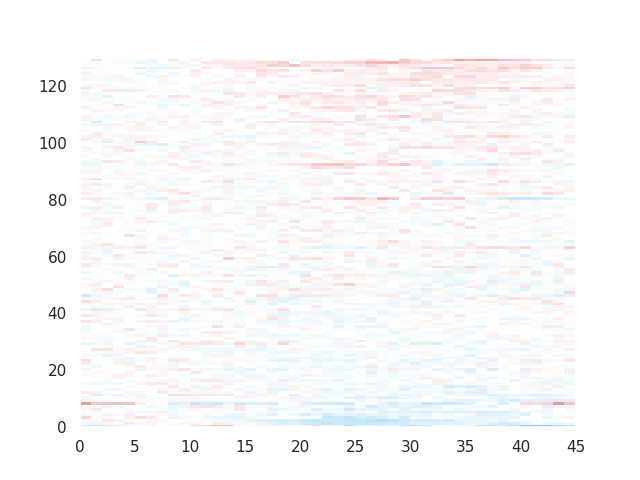

In [10]:
fig, ax = plt.subplots()
shuffle_order = np.argsort(shuffle[:, 15:].mean(1))
pool.plotting.graphfns.axheatmap(fig, ax, shuffle[shuffle_order], [], 'dff')

## Combined across days - late responses

In [11]:
mouse = flow.metadata.Mouse('OA205')
stims = ('plus', 'neutral', 'minus')
all_traces = {stim: [] for stim in stims}
all_response_0_2 = {stim: [] for stim in stims}
all_response_2_4 = {stim: [] for stim in stims}
all_response_3_5 = {stim: [] for stim in stims}
all_response_4_6 = {stim: [] for stim in stims}
roi_ids = []
for date in mouse.dates():
    traces = {stim: [] for stim in stims}
    for run in date.runs(['training']):
        t2p = run.trace2p()
        fr = t2p.framerate
        for stim in stims:
            run_traces = t2p.cstraces(
                stim, trace_type='dff', baseline=(-2, 0), start_s=-2, end_s=6)
            traces[stim].append(run_traces)
    roi_ids.extend([(date.date, idx) for idx in range(run_traces.shape[0])])
    for stim in stims:
        all_traces[stim].append(np.concatenate(traces[stim], 2).mean(2))
        all_response_0_2[stim].append(np.mean(all_traces[stim][-1][:, int(fr*(2+0)):int(fr*(2+2))], 1))
        all_response_2_4[stim].append(np.mean(all_traces[stim][-1][:, int(fr*(2+2)):int(fr*(2+4))], 1))
        all_response_3_5[stim].append(np.mean(all_traces[stim][-1][:, int(fr*(2+3)):int(fr*(2+5))], 1))
        all_response_4_6[stim].append(np.mean(all_traces[stim][-1][:, int(fr*(2+4)):int(fr*(2+6))], 1))
result, response_0_2, response_2_4, response_3_5, response_4_6 = {}, {}, {}, {}, {}
for stim in stims:
    result[stim] = np.concatenate(all_traces[stim], 0)
    response_0_2[stim] = np.concatenate(all_response_0_2[stim], 0)
    response_2_4[stim] = np.concatenate(all_response_2_4[stim], 0)
    response_3_5[stim] = np.concatenate(all_response_3_5[stim], 0)
    response_4_6[stim] = np.concatenate(all_response_4_6[stim], 0)     
    

  axis=1)



<IPython.core.display.Javascript object>


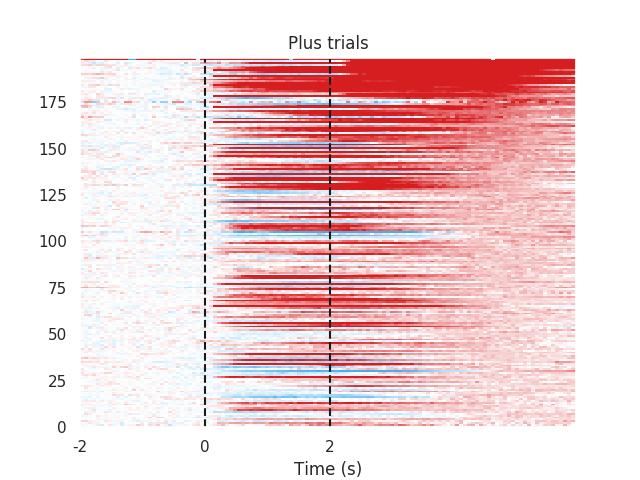

Text(0.5,1,'Plus trials')

In [12]:
fig, ax = plt.subplots()
order = np.argsort(response_3_5['plus'])
order_0_2 = np.argsort(response_0_2['plus'])
order_4_6 = np.argsort(response_4_6['plus'])
pool.plotting.graphfns.axheatmap(fig, ax, result['plus'][order_4_6[-200:]], [], tracetype='dff')
ax.set_xticks([0, 2*fr, 4*fr])
ax.set_xticklabels(["-2", "0", "2"])
ax.axvline(2*fr, color='k', linestyle='--')
ax.axvline(4*fr, color='k', linestyle='--')
ax.set_xlabel('Time (s)')
ax.set_title('Plus trials')

Largest responses during reward period show 3 distinct response profiles.

<IPython.core.display.Javascript object>


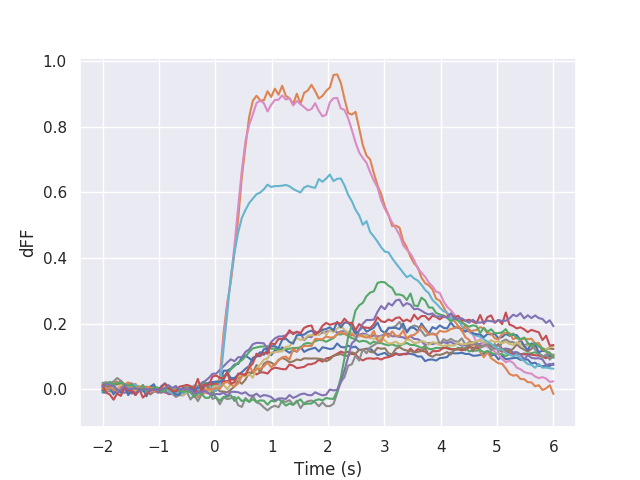

Text(0,0.5,'dFF')

In [13]:
fig, ax = plt.subplots()
ax.plot(np.linspace(-2, 6, result['plus'].shape[1]), result['plus'][order_4_6[-17:-2]].T)
ax.set_xlabel('Time (s)')
ax.set_ylabel('dFF')

In [14]:
np.array(roi_ids)[order_4_6[-17:-2]]

array([[180926,     91],
       [180926,      1],
       [180925,     65],
       [180925,     78],
       [180925,    105],
       [180927,     25],
       [180925,      0],
       [180926,      6],
       [180927,     19],
       [180927,      4],
       [180926,     94],
       [180926,     69],
       [180924,      9],
       [180926,    111],
       [180925,      8]])